In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as dsets
from torch.utils.data import Dataset,DataLoader
from torchvision import models

import cv2

import matplotlib.pyplot as plt

import time
import copy
import random as rd
import sys
import os
os.chdir("/juhyeong/projects/2019연구학점제/")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#codes.py
sys.path.insert(0, '../')
import codes

device = torch.device('cuda')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../../data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

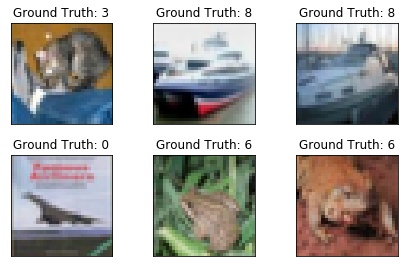

In [3]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i].transpose(0, 1).transpose(1, 2) + 1) / 2)
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [4]:
class flatten(nn.Module):
    def __init__(self):
        super(flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [5]:
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        self.means = codes.resnet152(pretrained = True)
        self.vars = codes.resnet152(pretrained = False)
        self.sample_net = codes.resnet152(pretrained = False)
        for var in self.vars.modules():
            if isinstance(var, nn.Conv2d):
                init.
            elif isinstance(var, nn.BatchNorm2d):
                sample.weight = torch.nn.Parameter(torch.randn(mean.weight.shape, device=device) * var.weight.exp() + mean.weight)
                sample.bias = torch.nn.Parameter(torch.randn(mean.bias.shape, device=device) * var.bias.exp() + mean.bias)
            elif isinstance(var, nn.Linear):
                sample.bias = torch.nn.Parameter(torch.randn(mean.bias.shape, device=device) * var.bias.exp() + mean.bias)
        
    def sample(self):
        for mean, var, sample in zip(self.means.modules(), self.vars.modules(), self.sample_net.modules()):
            if isinstance(sample, nn.Conv2d):
                sample.weight = torch.nn.Parameter(torch.randn(mean.weight.shape, device=device) * var.weight.exp() + mean.weight)
            elif isinstance(sample, nn.BatchNorm2d):
                sample.weight = torch.nn.Parameter(torch.randn(mean.weight.shape, device=device) * var.weight.exp() + mean.weight)
                sample.bias = torch.nn.Parameter(torch.randn(mean.bias.shape, device=device) * var.bias.exp() + mean.bias)
            elif isinstance(sample, nn.Linear):
                sample.bias = torch.nn.Parameter(torch.randn(mean.bias.shape, device=device) * var.bias.exp() + mean.bias)
            
        
    def forward(self, x):
        return self.sample_net(x)

model = BNN().cuda()

<h1>Training</h1>

In [6]:
epoch = 1000
lr = 1e-6
optimizer_means = torch.optim.Adam(model.means.parameters(), lr = lr)
optimizer_vars = torch.optim.Adam(model.vars.parameters(), lr = lr)

In [7]:
criterion = nn.CrossEntropyLoss()

In [ ]:
running_test_loss = 0.0
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    for ind, data in enumerate(trainloader):
        model.sample()
        optimizer_means.zero_grad()
        optimizer_vars.zero_grad()
        img, label = data
        output = model(img.cuda())
        loss = criterion(output, label.cuda())
        loss.backward()
        optimizer_means.step()
        optimizer_vars.step()
        train_loss += loss.detach()
    train_loss /= (len(trainloader) * 256)
    
    #Test
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for ind, data in enumerate(testloader):
            model.sample()
            img, label = data
            output = model(img.cuda())
            test_loss += criterion(output, label.cuda()).detach()
        test_loss /= (len(testloader) * 256)
        running_test_loss += test_loss.detach()
    print("epoch : %d,train loss = %5.5f, test loss = %5.5f, running test loss = %5.5f, time: %.2f sec"
          %(run, train_loss, test_loss, running_test_loss/(run + 1), time.time() - start))


epoch : 0,train loss = 0.04170, test loss = 17.26171, running test loss = 17.26171, time: 49.18 sec
epoch : 1,train loss = 0.04160, test loss = 16.59526, running test loss = 16.92848, time: 49.23 sec
epoch : 2,train loss = 0.04159, test loss = 12.99846, running test loss = 15.61847, time: 49.22 sec
epoch : 3,train loss = 0.04148, test loss = 20.64913, running test loss = 16.87614, time: 49.22 sec
epoch : 4,train loss = 0.04146, test loss = 18.76237, running test loss = 17.25338, time: 49.34 sec
epoch : 5,train loss = 0.04150, test loss = 16.05696, running test loss = 17.05398, time: 49.40 sec
epoch : 6,train loss = 0.04131, test loss = 15.38643, running test loss = 16.81576, time: 49.42 sec
epoch : 7,train loss = 0.04138, test loss = 11.93012, running test loss = 16.20505, time: 49.47 sec
epoch : 8,train loss = 0.04158, test loss = 18.48497, running test loss = 16.45838, time: 49.49 sec
epoch : 9,train loss = 0.04145, test loss = 18.72305, running test loss = 16.68484, time: 49.27 sec
